<Figure size 432x288 with 0 Axes>

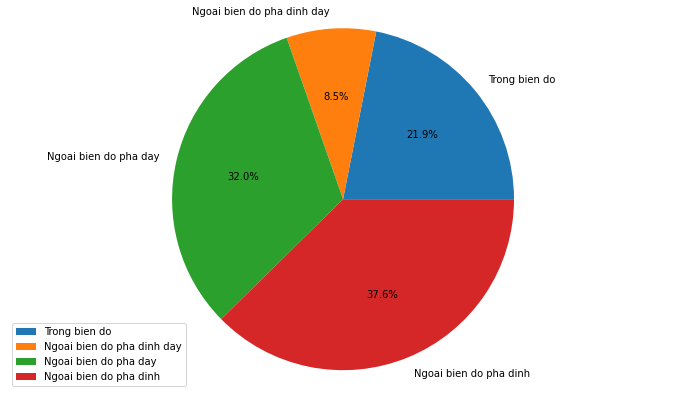

Đối với tập dự liệu giá BTC từ 2017-08-17 đến 2021-07-16, xác suất của việc mức giá cao nhất bị phá vỡ là 46.1%, mức giá thấp nhất bị phá vỡ là 40.5% và cả hai đỉnh đáy bị phá vỡ là 8.5%.
Có ít hơn 21.9% số ngày là những ngày giao dịch trong biên độ


In [43]:
from myenv.models.candlestick import Candlestick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


candlestick = Candlestick()

bitcoin_prices = candlestick.to_df()

bitcoin_prices.describe()

data = [0]

total = bitcoin_prices.date.count()

for index, row in bitcoin_prices.iterrows():
    if index < 1 or index > bitcoin_prices['close'].count() - 1:
        continue
    
    # trong biên độ
    inside_bar_type = 0

    if row['low'] < bitcoin_prices.iloc[index - 1]['low'] and row['high'] > bitcoin_prices.iloc[index - 1]['high']:
        # Ngoài biên độ phá vỡ đỉnh và dáy
        inside_bar_type = 1
    elif row['low'] < bitcoin_prices.iloc[index - 1]['low']:
        # Ngoài biên độ phá vỡ dáy
        inside_bar_type = 2
    elif row['high'] > bitcoin_prices.iloc[index - 1]['high']:
        # Ngoài biên độ phá vỡ đỉnh
        inside_bar_type = 3

    data.append(inside_bar_type)

bitcoin_prices['inside_bar_type'] = data

group_inside_bar_type = bitcoin_prices.groupby(
    'inside_bar_type').inside_bar_type.count()

labels = 'Trong bien do', 'Ngoai bien do pha dinh day', 'Ngoai bien do pha day', 'Ngoai bien do pha dinh'
sizes = [group_inside_bar_type.loc[0],
         group_inside_bar_type.loc[1], group_inside_bar_type.loc[2], group_inside_bar_type.loc[3]]

plt.figure()
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend()
plt.show()

first_date = bitcoin_prices.loc[0, 'date'].date()
last_date = bitcoin_prices.iloc[-1, 0].date()
probability_break_high = '{:.1%}'.format((group_inside_bar_type.loc[3] +
                                          group_inside_bar_type.loc[1])/total)
probability_break_low = '{:.1%}'.format((group_inside_bar_type.loc[2] +
                                         group_inside_bar_type.loc[1])/total)
probability_break_both = '{:.1%}'.format(group_inside_bar_type.loc[1]/total)
probability_inside_day = '{:.1%}'.format(group_inside_bar_type.loc[0]/total)

print(
    f"Đối với tập dự liệu giá BTC từ {first_date} đến {last_date}, xác suất của việc mức giá cao nhất bị phá vỡ là {probability_break_high}, mức giá thấp nhất bị phá vỡ là {probability_break_low} và cả hai đỉnh đáy bị phá vỡ là {probability_break_both}.")
print(
    f"Có ít hơn {probability_inside_day} số ngày là những ngày giao dịch trong biên độ")


Đối với tập dự liệu giá từ 2017-08-17 đến 2021-07-16, xác suất của việc mưc giá cao nhất bị phá vỡ là 4608.4%, mức giá thấp nhất là 4049.0% và cả hai đỉnh đáy là 846.2%.
Có ít hơn 2188.8% số ngày là những ngày giao dịch trong biên độ


In [25]:
bitcoin_prices.date.count()

1430